In [14]:
from nilearn import plotting
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cross_decomposition import PLSRegression, CCA
import regression_common
import joblib
import matplotlib.pyplot as plt

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

In [3]:
if True: # to be done once only
    
    # Create/store/load binary image data
    if not os.path.isfile('../data/binary_imgs.npy'):

        dataset_path = "../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
        img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
        img_filenames.sort()
        print('Number of subjects: %d' % len(img_filenames))

        img_shape = load_img(img_filenames[0]).shape

        mask_img = load_mni152_brain_mask()
        masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
        masker = masker.fit()

        imgs = masker.transform(img_filenames) # break down into slices if necessary
        imgs = imgs.astype(bool)
        np.save('../data/binary_imgs', imgs)

    else:
        imgs = np.load('../data/binary_imgs.npy')

    print(imgs.shape)

(1401, 228453)


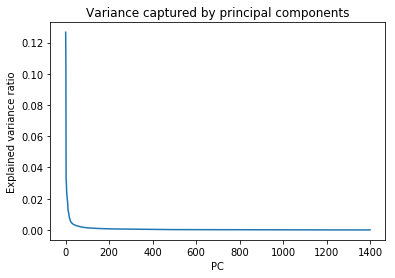

In [12]:
# plot variance explained by components
if not os.path.isfile('../data/pca_all.joblib'): 
    pca_all = PCA(copy=False)
    X_pc_all = pca_all.fit_transform(imgs)
    #np.save('../data/binary_imgs_pc_all.npy', X_pc_all)
    joblib.dump(pca_all, '../data/pca_all.joblib') 

else:
    pca_all = joblib.load('../data/pca_all.joblib') 
    
plt.plot(pca_all.explained_variance_ratio_)
plt.title("Variance captured by principal components")
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.show()

## Multitask analysis with 100 PC components

In [19]:
# Calculate 100 PC components
if not os.path.isfile('../data/binary_imgs_pc_100.npy'):    
    pca = PCA(n_components=100)
    X_pc = pca.fit_transform(imgs)
    np.save('../data/binary_imgs_pc_100.npy', X_pc)
    
else:
    X_pc = np.load('../data/binary_imgs_pc_100.npy')
    
X_pc.shape

(1401, 100)

In [20]:
patient_df = pd.read_hdf('../data/patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))

### Multitask Ridge

In [33]:
def perform_multitask_ridge(X, Y):
    print('Performing Multitask Ridge regression (5-fold nested CV)')
    estimator = MultiTaskElasticNet(l1_ratio=0.001)
    alpha = np.linspace(0, 100, 51)
    my_grid={"alpha": alpha}
    return perform_regression(X, Y, estimator, my_grid, pca_fold=True)

In [38]:
scores_mr = perform_multitask_ridge(X_pc, Y)

Performing Multitask Ridge regression (5-fold nested CV)

Fold-1: Best params: {'alpha': 54.0}

Fold-2: Best params: {'alpha': 34.0}

Fold-3: Best params: {'alpha': 32.0}

Fold-4: Best params: {'alpha': 22.0}

Fold-5: Best params: {'alpha': 40.0}


### PLS

In [40]:
def perform_pls_regression(X, Y):
    print('Performing PLS regression (5-fold nested CV)')
    estimator = PLSRegression()
    n_components = np.linspace(1, 6, 6, dtype=int)
    my_grid={'n_components': n_components}
    return perform_regression(X, Y, estimator, my_grid, pca_fold=True)

In [41]:
scores_pls = perform_pls_regression(X_pc, Y)

Performing PLS regression (5-fold nested CV)

Fold-1: Best params: {'n_components': 1}

Fold-2: Best params: {'n_components': 1}

Fold-3: Best params: {'n_components': 1}

Fold-4: Best params: {'n_components': 1}

Fold-5: Best params: {'n_components': 1}


### CCA

In [44]:
def perform_cca(X, Y):
    print('Performing CCA (5-fold nested CV)')
    estimator = CCA(n_components=6)
    n_components = np.linspace(1, 6, 6, dtype=int)
    my_grid={'n_components': n_components}
    return perform_regression(X, Y, estimator, my_grid, pca_fold=True)

In [45]:
scores_cca = perform_cca(X_pc, Y)

Performing CCA (5-fold nested CV)

Fold-1: Best params: {'n_components': 1}

Fold-2: Best params: {'n_components': 1}

Fold-3: Best params: {'n_components': 1}

Fold-4: Best params: {'n_components': 1}

Fold-5: Best params: {'n_components': 1}


### Random Forest Regression

In [46]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV)')
    estimator = RandomForestRegressor(random_state=39)

    n_estimators = [100, 500, 1000, 1500]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [2, 5, 10, 50, None]
    min_samples_split = [1, 2, 5, 10, 15]
    min_samples_leaf = [2, 4, 8, 12]
    max_samples = [0.5, 0.7, 0.8, 0.9]
    
    my_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
    
    return perform_regression(X, Y, estimator, my_grid, random_search_cv=True, pca_fold=True)

In [47]:
scores_rf = perform_random_forest_regr(X_pc, Y)

Performing Random Forest regression (5-fold nested CV)

Fold-1: Best params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'auto', 'max_depth': 5}

Fold-2: Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_samples': 0.7, 'max_features': 'auto', 'max_depth': 5}

Fold-3: Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 50}

Fold-4: Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': 50}

Fold-5: Best params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.9, 'max_features': 'log2', 'max_depth': 10}


### Neural Net 

In [71]:
# For fun
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

def get_nn_model():
    model = Sequential()
    model.add(Dense(25, input_dim=100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation=None))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def perform_nn_regr(X, Y):
    print('Performing Neural Network regression (5-fold nested CV)')
    estimator = KerasRegressor(build_fn=get_nn_model, epochs=2, batch_size=512, verbose=1)
    return perform_regression(X, Y, estimator, {}, nn=True, pca_fold=True)

In [72]:
scores_nn = perform_nn_regr(X_pc, Y)

Performing Neural Network regression (5-fold nested CV)
Train on 1120 samples, validate on 281 samples
Epoch 1/2
1120/1120 [==============================] - 2s 2ms/step - loss: 0.9910 - val_loss: 1.0392
Epoch 2/2
281/281 [==============================] - 0s 7us/step

Fold-1: Best params: {}
Train on 1121 samples, validate on 280 samples
Epoch 1/2
1121/1121 [==============================] - 2s 2ms/step - loss: 0.9834 - val_loss: 1.0673
Epoch 2/2
280/280 [==============================] - 0s 9us/step

Fold-2: Best params: {}
Train on 1121 samples, validate on 280 samples
Epoch 1/2
1121/1121 [==============================] - 2s 2ms/step - loss: 0.9795 - val_loss: 1.0823
Epoch 2/2
280/280 [==============================] - 0s 8us/step

Fold-3: Best params: {}
Train on 1121 samples, validate on 280 samples
Epoch 1/2
1121/1121 [==============================] - 2s 1ms/step - loss: 1.0186 - val_loss: 0.9267
Epoch 2/2
280/280 [==============================] - 0s 6us/step

Fold-4: Best par

In [73]:

scores_all_models = pd.DataFrame()

scores_mr.insert(0, "Model", "Multitask Ridge")
scores_pls.insert(0, "Model", "PLS")
scores_cca.insert(0, "Model", "CCA")
scores_rf.insert(0, "Model", "Random Forest")
scores_nn.insert(0, "Model", "Neural Network")

scores_all_models = pd.concat([scores_mr, scores_pls, scores_cca, scores_rf, scores_nn], ignore_index=True)

In [74]:
# persist results
scores_all_models.to_hdf('../data/results_pca_100_inside_cv_multioutput.h5', key='p', mode='w')
#scores_all_models = pd.read_hdf('../data/results_pca_100_inside_cv_multioutput.h5', key='p', mode='r')

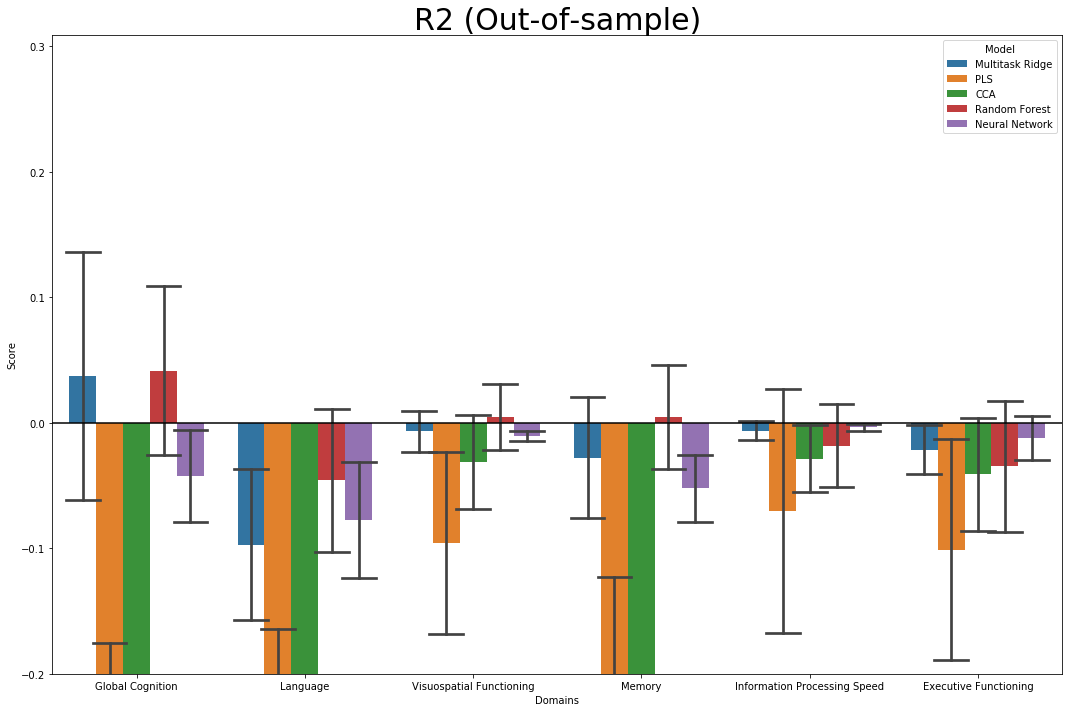

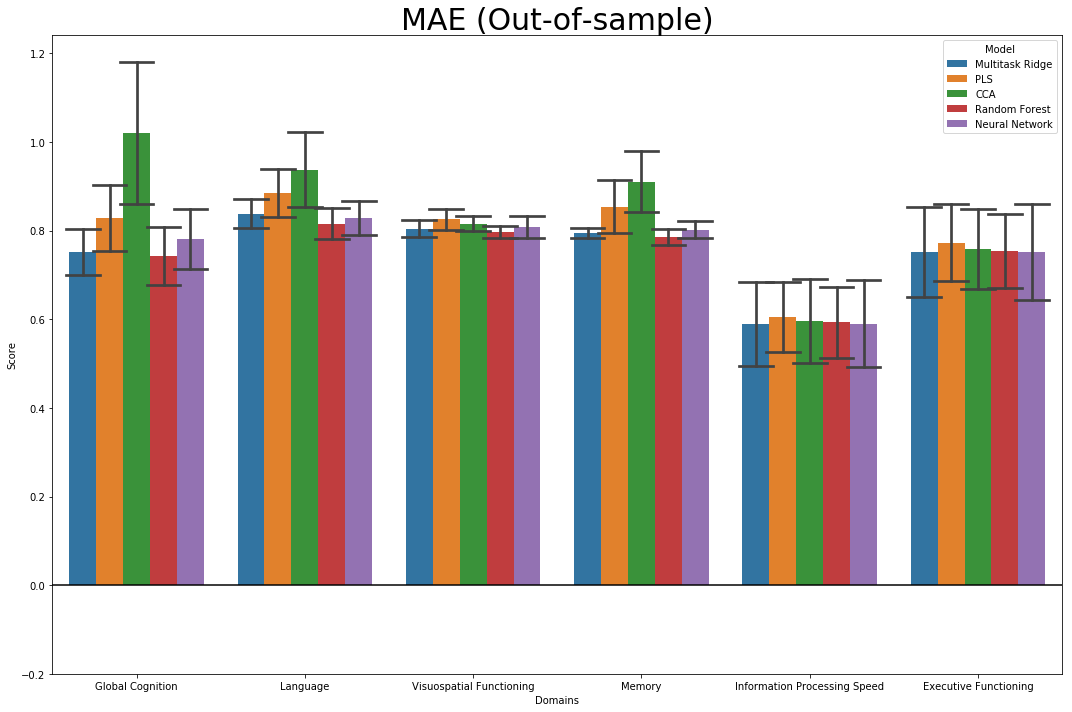

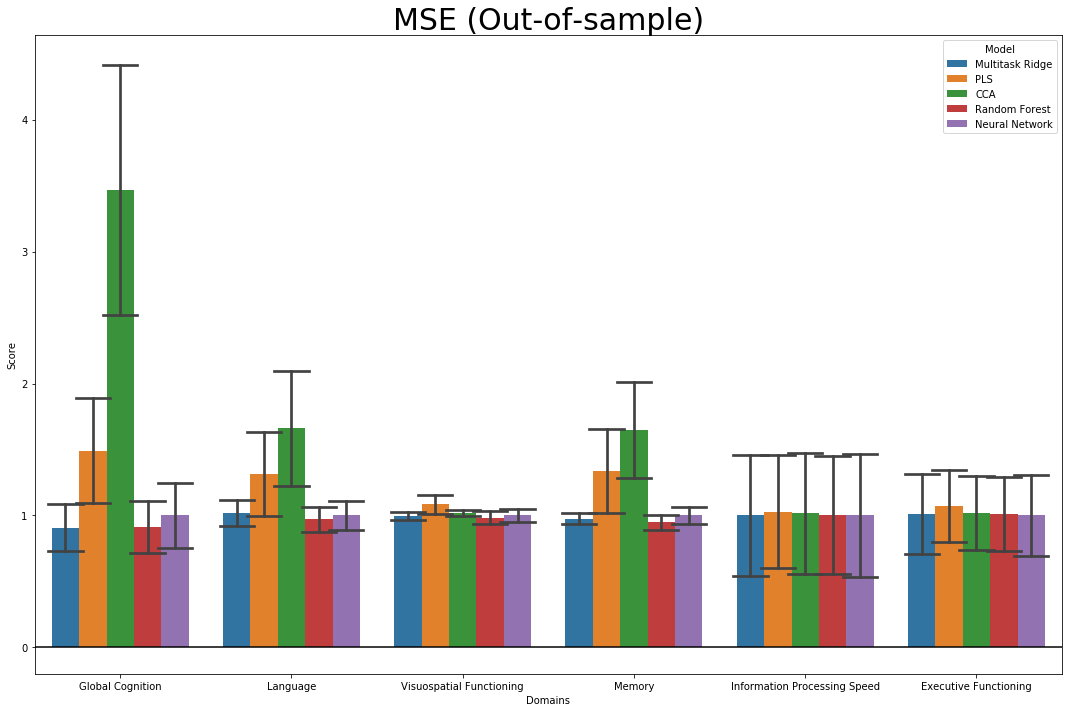

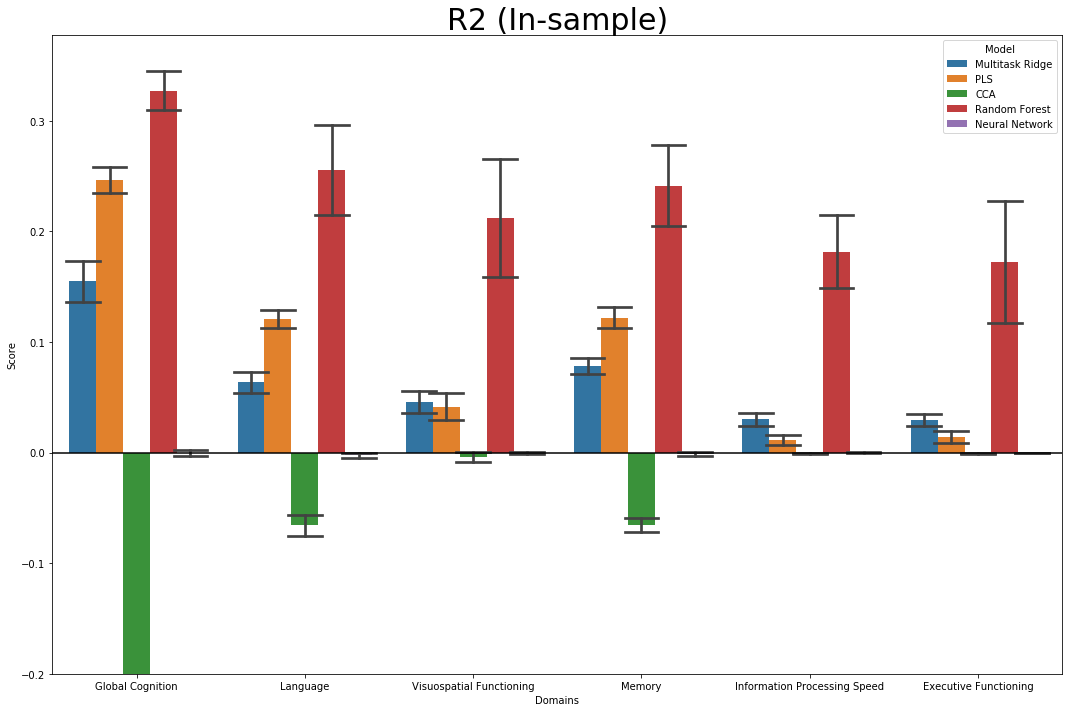

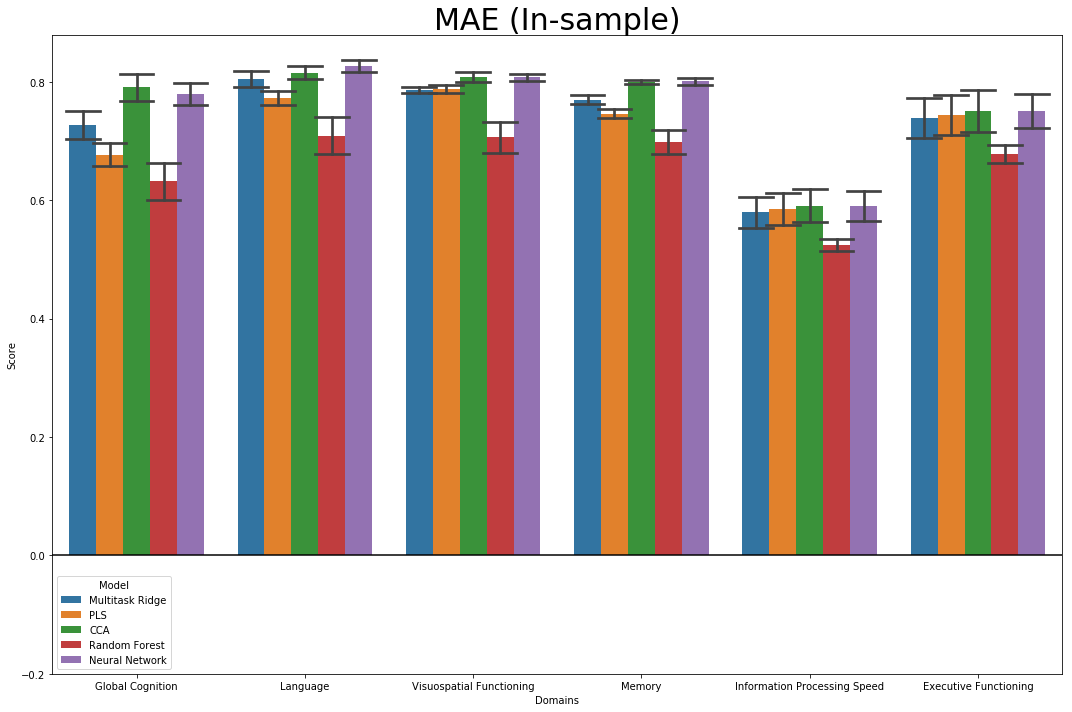

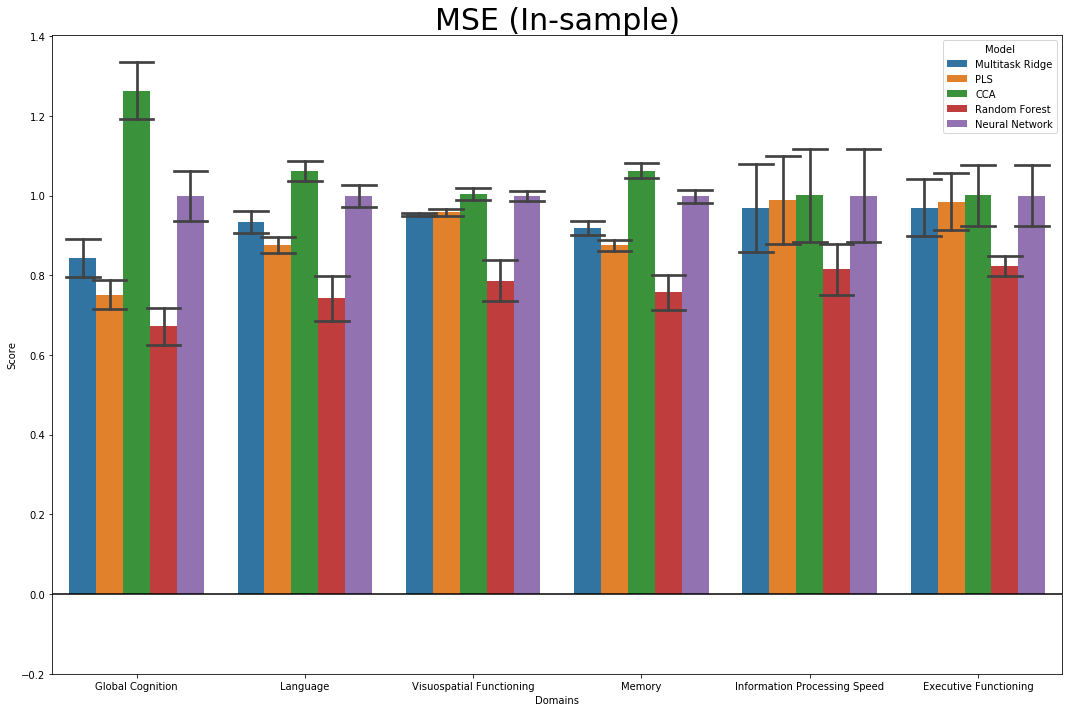

In [75]:
# Plot results
regression_common.plot_all_scores(scores_all_models)

In [ ]:
// Done